# TCC Especialização em Inteligência  Artificial Aplicada - Facens 2019/2

### Tema

* Face Anti-Spoofing Comparando arquiteturas de deep learning com técnicas  de transfer learning

### Nomes dos integrantes:

* Osmar do Prado Jr. - (191520)
* Ricardo da Silva. - (191521)

### Orientador:
* Johannes Lochter


### Github
Todos os exemplo são encontrados no repositório publico Github:
* https://github.com/RicaJedidia/Facens_TCC_Face_Anti_Spoofing


### Referência  CelebA-Spoof Dataset 
* https://github.com/Davidzhangyuanhan/CelebA-Spoof
* https://paperswithcode.com/dataset/celeba-spoof

*O conjunto de dados CelebA-Spoof está disponível apenas para fins de pesquisa não comercial.*

### Introdução
O reconhecimento facial está entre as tecnologias biométricas mais estudadas desde a década de 90, principalmente por suas inúmeras vantagens em relação às demais biometrias. Muitas empresas estão implementando a tecnologia de reconhecimento facial em seus aplicativos de serviço, varejo ou bancos digitais.
Dada a popularidade dos sistemas de autenticação facial, eles se tornaram os alvos principais dos ataques de apresentação que são realizados por usuários  mal-intencionados, que visam personificar a identidade de outra pessoa (ataque de personificação) ou evitar serem reconhecidos pelo sistema (ataque de ofuscação).
O objetivo deste trabalho é apresentar uma comparação das arquiteturas de modelos de inteligência artificial na identificação de imagens categorizadas em 'live' ou 'spoof' ('real' ou 'falso').

### Base de dados
Para este estudo foi utilizado 32.000 imagens com faces já pré processadas (Crop) da base de dados CelebA-Spoof Dataset.

Os dados estão separados da seguinte maneira:

* 25.000 Treino 
 * 12.581 live
  * 12.419 spoof
* 7.000 teste 
 * 3.500 live
  * 3.500 spoof

### Download CelebA_Spoof_32k.zip
* https://drive.google.com/file/d/1ZocQKFCabv4xbzDutmsa0wlkJQV6_DqT/view?usp=sharing

### Tipos de imagens Spoof

![img_type.png](../img/img_type.png)




### Setup utilizado
Inicialmente utilizamos o google [Colab](https://colab.research.google.com) compartilhado entre os integrantes, entretanto por motivos de limitações do próprio site (90 minutos de inatividade), foi necessário realizar os últimos testes em uma máquina local.

Segue abaixo o setup utilizado:

#### Hardware
* CPU: Intel Core i7-7700 @ 3.60 Hz
* Placa de video: NVIDIA GeForge GTX 1060 6GB
* RAM: 16.0 GB
* Disco: SSD KINGSTION SA400S37120G

#### Software
* Windows 10 x64
* Cuda 11.1
* Tensorflow:  2.1.0
* Keras:  2.2.4-tf

### Resumo
Foram criados 5 arquiteturas de modelos de deep learning para comparação, todos começam com o input de (244, 244, 3) e output de (2)

![img_models.png](../img/img_models.png)


### Modelos escolhidos
Segue abaixo a lista dos 5 modelos escolhidos com o link do seu respectivo repositorio.
* [MobileNetV2](https://github.com/RicaJedidia/Facens_TCC_Face_Anti_Spoofing/tree/main/teste_01_MobileNetV2)
* [Densenet 121](https://github.com/RicaJedidia/Facens_TCC_Face_Anti_Spoofing/tree/main/teste_02_Densenet_121)
* [Vgg 16](https://github.com/RicaJedidia/Facens_TCC_Face_Anti_Spoofing/tree/main/teste_03_Vgg16)
* [Vgg 19](https://github.com/RicaJedidia/Facens_TCC_Face_Anti_Spoofing/tree/main/teste_04_Vgg19)
* [Xception](https://github.com/RicaJedidia/Facens_TCC_Face_Anti_Spoofing/tree/main/teste_05_Xception)



### Carregando bibliotecas

In [1]:
import numpy as np
import pandas as pd

import cv2
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import Xception

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

# gráfico
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Uso de GPU
Checando o recursos de ambiente com GPU habilitado

In [2]:
print('Tensorflow version: ', tf.version.VERSION)
print('Keras version: ', tf.keras.__version__)

Tensorflow version:  2.1.0
Keras version:  2.2.4-tf


In [3]:
!nvidia-smi

Tue Apr 20 22:58:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.30       Driver Version: 457.30       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P8     9W / 120W |    761MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Iniciando variaveis

In [4]:
LOCAL_ROOT  = 'D:/CelebA_Spoof_32k'
PATH_TEST = LOCAL_ROOT +  '/test'

BATCH_SIZE = 64
IMG_SHAPE = (224, 224, 3)
RANDOM_STATE = 42

In [5]:
path_MobileNetV2 = '../teste_01_MobileNetV2/CelebA_Spoof_32k_MobileNetV2_50.h5'
path_DenseNet121 = '../teste_02_Densenet_121/CelebA_Spoof_32k_DenseNet121_50.h5'
path_Vgg16 = '../teste_03_Vgg16/CelebA_Spoof_32k_Vgg16_50.h5'
path_Vgg19 = '../teste_04_Vgg19/CelebA_Spoof_32k_Vgg19_50.h5'
path_Xception = '../teste_05_Xception/CelebA_Spoof_32k_Xception.h5'

### Separando dados para teste

In [6]:
test_datagen = ImageDataGenerator(rescale = 1.0/255)

In [7]:
test_generator = test_datagen.flow_from_directory(PATH_TEST,
                                                   target_size=IMG_SHAPE[:-1],
                                                   shuffle=False,
                                                   class_mode='binary',
                                                   batch_size=BATCH_SIZE)

Found 7000 images belonging to 2 classes.


### Visualizando as imagens

In [8]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

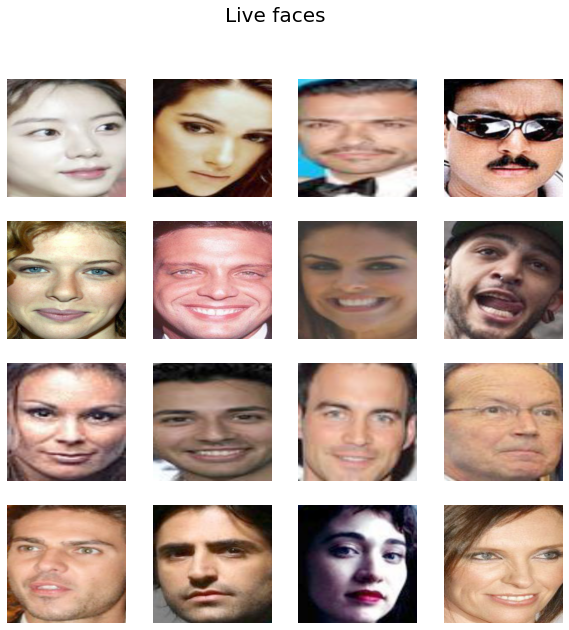

In [9]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(test_generator.filepaths[i]), cmap='gray')
    plt.suptitle("Live faces",fontsize=20)
    plt.axis('off')

plt.show()

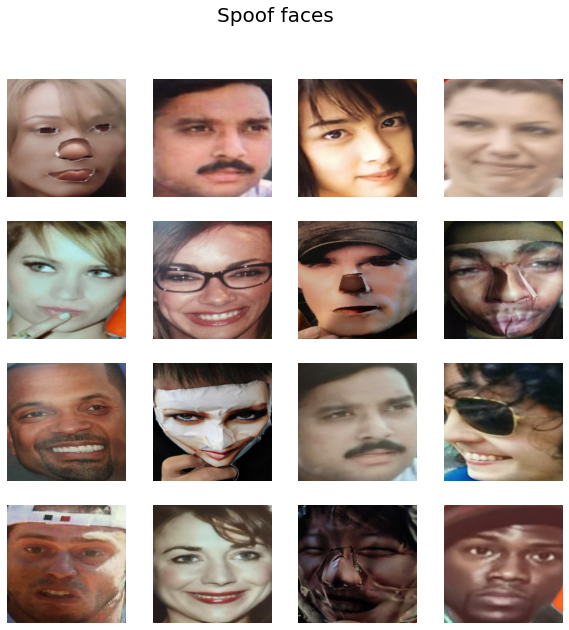

In [10]:
fig = plt.figure(figsize=(10, 10))

i = 0
for n in range(6984, 7000):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(test_generator.filepaths[n]), cmap='gray')
    plt.suptitle("Spoof faces",fontsize=20)
    plt.axis('off')
    i = i + 1

plt.show()

## Carregando modelos
Para manter a compatibilidade de versão será necessário mantar a arquitetura do modelo e carregar os pesos.

### Model MobileNetV2

In [11]:
mobilenet = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [12]:
model_MobileNetV2 = tf.keras.models.Sequential([mobilenet,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])

In [13]:
model_MobileNetV2.load_weights(path_MobileNetV2)
model_MobileNetV2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### DenseNet121

In [14]:
densenet = DenseNet121(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [15]:
model_DenseNet121 = tf.keras.models.Sequential([densenet,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])

In [16]:
model_DenseNet121.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [17]:
model_DenseNet121.load_weights(path_DenseNet121)

### VGG16

In [18]:
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [19]:
model_vgg16 = tf.keras.models.Sequential([vgg16,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])

In [20]:
model_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [21]:
model_vgg16.load_weights(path_Vgg16)

### VGG19

In [22]:
vgg19 = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [23]:
model_vgg19 = tf.keras.models.Sequential([vgg19,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])

In [24]:
model_vgg19.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

In [25]:
model_vgg19.load_weights(path_Vgg19)

### Xception

In [26]:
xception = Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [27]:
model_Xception = tf.keras.models.Sequential([xception,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])

In [28]:
model_Xception.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

In [29]:
model_Xception.load_weights(path_Xception)

### Avaliando os modelos

In [30]:
models = [model_MobileNetV2, model_DenseNet121, model_vgg16,  model_vgg19, model_Xception]
names = ['MobileNetV2', 'DenseNet121', 'Vgg16', 'Vgg19', 'Xception']

In [31]:
def evaluate(models, generator, names):
    results = pd.DataFrame(columns=['accuracy', 'f1-score', 'precision'])
    
    for model, name in zip(models, names):
        print('Avaliando: {}'.format(name))
        pred = model.predict(generator, verbose=1)

        y_test = generator.classes
        y_pred = pred.argmax(axis=1)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)

        results.loc[name, :] = [accuracy, f1, precision]
    
    return results

In [32]:
results = evaluate(models, test_generator, names)

Avaliando: MobileNetV2
110/110 [==============================] - 17s 159ms/step
Avaliando: DenseNet121
110/110 [==============================] - 30s 275ms/step
Avaliando: Vgg16
110/110 [==============================] - 46s 418ms/step
Avaliando: Vgg19
110/110 [==============================] - 49s 443ms/step
Avaliando: Xception
110/110 [==============================] - 40s 360ms/step


In [33]:
results

,accuracy,f1-score,precision
MobileNetV2,0.917857,0.911087,0.992922
DenseNet121,0.870714,0.852774,0.990178
Vgg16,0.881857,0.869538,0.970764
Vgg19,0.906286,0.899325,0.971485
Xception,0.870429,0.851433,0.997697


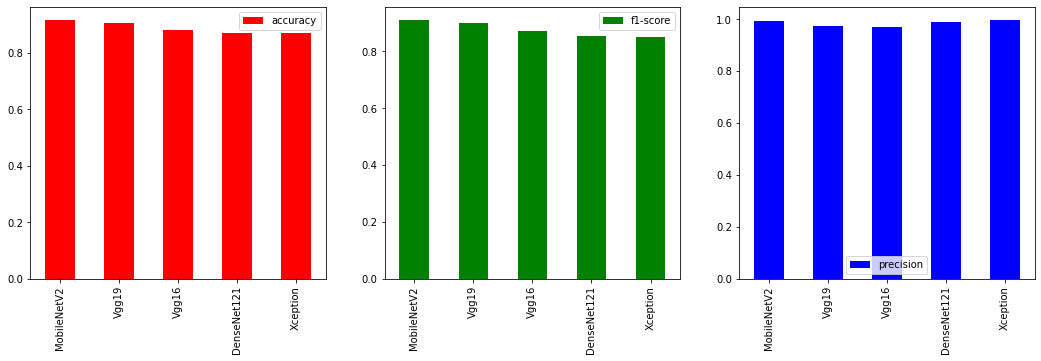

In [34]:
fig, ax = plt.subplots(1,3, figsize=(18,5))

results.sort_values('accuracy', ascending=False).plot.bar(y='accuracy', color='r', ax=ax[0])
results.sort_values('f1-score', ascending=False).plot.bar(y='f1-score', color='g', ax=ax[1])
results.sort_values('accuracy', ascending=False).plot.bar(y='precision', color='b', ax=ax[2])

In [35]:
results['Total params'] =[2981826, 7630274, 15045314, 20355010, 21978538]
results['Tempo de Treino'] = ['3h30m', '4h30m', '5h40m', '6h05m', '7h20m']
results['Tempo de Avaliação'] = ['140ms/step', '251ms/step', '382ms/step', '410ms/step', '331ms/step']
results

,accuracy,f1-score,precision,Total params,Tempo de Treino,Tempo de Avaliação
MobileNetV2,0.917857,0.911087,0.992922,2981826,3h30m,140ms/step
DenseNet121,0.870714,0.852774,0.990178,7630274,4h30m,251ms/step
Vgg16,0.881857,0.869538,0.970764,15045314,5h40m,382ms/step
Vgg19,0.906286,0.899325,0.971485,20355010,6h05m,410ms/step
Xception,0.870429,0.851433,0.997697,21978538,7h20m,331ms/step


### Conclusão

Executando todos os modelos podemos observar que:
* Existe uma diferença significativa de Tempo de treino
* Existe uma diferença significativa de Tempo de avaliação
* O valores de accuracy, f1-score e precision são relativamentes próximos

A arquitetura MobileNetV2 foi considerada o melhor modelo, uma vez que teve os melhores valores de accuracy, f1-score e precision e processamenta mais rapido mesmo contendo menos parametros.